# Master model development

## John Brandt

### Last updated: November 16 2019

*  Package loading
*  Hyperparameter definitions
*  Additional layer definitions
*  Model definition
*  Data loading
*  Data preprocessing
*  K means clustering
*  Augment training data
*  Loss definition
*  Equibatch creation
*  Model training
*  Model validation and sanity checks

# Experiment log
*  Master version - 0.620 F1 after 70 epochs
    * Stacked 1x1 intro conv + conv - selu, no BN - 0.616 after 20 epochs
    * Remove 2 Conv Selus, GRU - FPA - Conv - Sigmoid, 60k params, 0.6
    * New indices are calculated correctly
    * Simpler FPA is more efficient with more stable learning
    * Lovasz works best per-image (0.61 vs. 0.56)
    * Boundary loss overfits with non-smoothed data
    * 14x14 input is a bad idea, because the border pixel makes sense for the final 3x3 conv
    * Temporal attention and CSSE work together
    * Min max scaling does not work
    * [-1, 1] scaling is better than [0, 1] scaling
    * DEM messes everything up because of banding every 10-15 meters, removing the slope improves test accuracy, but median filter with size of 5 may fix this issue
    * Smoothing the time dimension seems to help
    
* Reduced parameter size to 10, 24, 24 -- 0.61

* Smooth time dimension for all variable bands --

* Stack FPA module rather than FPA - Conv SELU

* FPA GRU - 1x1 GRU, 3x3 GRU, 5x5 Dilated GRU, combine hidden states within GRU

* Test adding versus multiplying for the concatenation of scales

In [1]:
#TODO Remove imports that aren't needed to save RAM
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add, Bidirectional, ConvLSTM2D
from tensorflow.python.keras.activations import selu
from tensorflow.initializers import glorot_normal, lecun_normal

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import conv2d

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
%run ../src/zoneout.py
%run ../src/convgru.py
%run ../src/lovasz.py
%run ../src/utils.py
%run ../src/adabound.py
%run ../src/slope.py
%run ../src/dropblock.py

# Hyperparameter definitions

In [3]:
ZONE_OUT_PROB = 0.35
L2_REG = 0.0
INITIAL_LR = 2e-4
FINAL_LR = 1e-3
BN_MOMENTUM = 0.9
BATCH_SIZE = 16
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
MAX_DROPBLOCK = 0.85

gru_flt = 14
fpa_flt = 16
out_conv_flt = 20


AUGMENTATION_RATIO = 4
IMAGE_SIZE = 16
existing = [int(x[:-4]) for x in os.listdir('../data/training-data-nov-22/') if ".DS" not in x]
N_SAMPLES = len(existing)

LABEL_SIZE = 14

    
TRAIN_SAMPLES = int((N_SAMPLES * AUGMENTATION_RATIO) * TRAIN_RATIO)
TEST_SAMPLES = int((N_SAMPLES * AUGMENTATION_RATIO) - TRAIN_SAMPLES)
print(TRAIN_SAMPLES // AUGMENTATION_RATIO, N_SAMPLES - (TRAIN_SAMPLES // AUGMENTATION_RATIO))

590 148


# Additional layer definitions

Some of these may be able to be removed, or moved to a src/*.py

*  Conv SELU
*  Conv BN ELU
*  Feature pyramid attention (with downsample / upsample)
*  Feature pyramid attention (w/o downsample / upsample)
*  Temporal attention
*  CSE, SSE, cCSE
*  Reflection padding


In [4]:
def conv_bn_elu(inp, is_training, kernel_size, scope, filter_count = 16, pad = True, padding = 'valid', dilated = False):
    if not dilated:
        padded = ReflectionPadding2D((1, 1,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = selu,
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    if not dilated and not pad:
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = selu,
                        padding = padding, kernel_initializer = lecun_normal())(inp)
    if dilated:
        padded = ReflectionPadding2D((2, 2,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (3, 3), activation = selu, dilation_rate = (2, 2),
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    return conv
    
def fpa(inp, is_training, filter_count):
    one = conv_bn_elu(inp, is_training, 1, 'forward1', filter_count, False, 'valid')
    five = conv_bn_elu(inp, is_training, 5, 'down1', filter_count, False, 'valid')
    five_f = conv_bn_elu(five, is_training, 5, 'down1_f', filter_count, False, 'valid')
    three = conv_bn_elu(five, is_training, 3, 'down2', filter_count, False, 'valid')
    three_f = conv_bn_elu(three, is_training, 3, 'down2_f', filter_count, False, 'valid')
    
    three_up = get_deconv2d(three_f, filter_count, filter_count, "fpa1", is_training)
    five_up = get_deconv2d(five_f, filter_count, filter_count, "fpa2", is_training)
    
    print("One: {}".format(one.shape))
    print("Five: {}".format(five.shape))
    print("Five_F: {}".format(five_f.shape))
    print("Three: {}".format(three.shape))
    print("Three_f: {}".format(three_f.shape))
    print("Three_up: {}".format(three_up.shape))
    print("Five_up: {}".format(five_up.shape))
    
    # top block
    pooled = tf.keras.layers.GlobalAveragePooling2D()(inp)
    one_top = conv_bn_elu(tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
                          is_training, 1, 'top1', filter_count, pad = False)
    four_top = tf.keras.layers.UpSampling2D((16, 16))(one_top)
    print("Sixteen top: {}".format(four_top.shape))
    
    
    concat_1 = tf.multiply(one, tf.add(three_up, five_up))
    concat_2 = tf.add(concat_1, four_top)
    print("Feature pyramid attention shape {}".format(concat_2.shape))
    return concat_2

#def fpa(inp, is_training, filter_count, scope = 'fpa', topblock = False):
#    one = conv_bn_elu(inp, is_training, 1, scope + 'forward1', filter_count, False, 'valid')
#    three = conv_bn_elu(inp, is_training, 3, scope + 'down2', filter_count, True, 'valid') 
#    five = conv_bn_elu(inp, is_training, 3, scope + 'down2', filter_count, True, 'valid', dilated = True) 
#    concat_1 = tf.multiply(one, tf.add(three, five))
    
#    if topblock:
#        pooled = tf.keras.layers.GlobalAveragePooling2D()(inp)
#        one_top = conv_bn_elu(tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
#                              is_training, 1, 'top1', filter_count, pad = False)
#        four_top = tf.keras.layers.UpSampling2D((16, 16))(one_top)
#        print("Sixteen top: {}".format(four_top.shape))
#
#        concat_1 = tf.add(concat_1, four_top)
    
#    return concat_1

    
def create_deconv_init(filter_size, num_channels):
    bilinear_kernel = np.zeros([filter_size, filter_size], dtype=np.float32)
    scale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = scale_factor - 1
    else:
        center = scale_factor - 0.5
    for x in range(filter_size):
        for y in range(filter_size):
            bilinear_kernel[x,y] = (1 - abs(x - center) / scale_factor) * \
                                   (1 - abs(y - center) / scale_factor)
    weights = np.zeros((filter_size, filter_size, num_channels, num_channels))
    for i in range(num_channels):
        weights[:, :, i, i] = bilinear_kernel

    #assign numpy array to constant_initalizer and pass to get_variable
    bilinear_init = tf.constant_initializer(value=weights, dtype=tf.float32)
    return bilinear_init


def get_deconv2d(inp, filter_count, num_channels, scope, is_training):
    bilinear_init = create_deconv_init(4, filter_count)
    x = tf.keras.layers.Conv2DTranspose(filters = filter_count, kernel_size = (4, 4),
                                        strides=(2, 2), padding='same', 
                                        kernel_initializer = bilinear_init)(inp)
    x = ELU()(x)
    x = Batch_Normalization(x, training=is_training, scope = scope + "bn")
    return x


def Batch_Normalization(x, training, scope):
    return batch_normalization(inputs=x, 
                               momentum = BN_MOMENTUM, 
                               training=training,
                               renorm = True,
                               reuse=None,
                               name = scope)

def temporal_attention(inp, units):
    # This rescales each output
    # Timesteps that are more important get weighted higher
    # Timesteps that are least important get weighted lower --> B, N, H, W, C
    conved = TimeDistributed(Conv2D(units, (1, 1), padding = 'same', kernel_initializer = 'glorot_uniform',
                            activation = 'tanh', strides = (1, 1)))(inp)
    
    
    #conved = tf.reshape(conved, (-1, units, 16, 16, STEPS))
    print("Attention weight shape: {}".format(conved.shape))
    conved = TimeDistributed(Conv2D(1, (1, 1), padding = 'same', kernel_initializer = 'glorot_uniform',
                            activation = 'sigmoid', use_bias = False, strides = (1, 1)))(conved)
    print("Conved sigmoid shape: {}".format(conved.shape))
    #conved = tf.reshape(conved, (-1, 24, 1, 1, 1))
    
    alphas = tf.reduce_sum(conved, axis = 1, keep_dims = True)
    print("Attention alphas: {}".format(alphas.shape))
    # We need to calculate the total sum for each pixel for each channel, so that we can combine them
    alphas = conved / alphas
    print("Attention weight shapes {}".format(alphas.shape))
    
    # This actually multiplies the Conv by the input
    multiplied = tf.reduce_sum(alphas * inp, axis = 1)
    return multiplied

In [5]:
def cse_block(prevlayer, prefix):
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x


def sse_block(prevlayer, prefix):
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer="glorot_uniform",
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''
    Implementation of Concurrent Spatial and Channel ‘Squeeze & Excitation’ in Fully Convolutional Networks
    https://arxiv.org/abs/1803.02579
    '''
    cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    x = Add(name=prefix + "_csse_mul")([cse, sse])

    return x

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
    
def gru_block(inp, length, size, flt, scope, train, normalize = True):
    with tf.variable_scope(scope):
        print("GRU input shape {}, zoneout: {}".format(inp.shape, ZONE_OUT_PROB))
        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, fpa = True)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, fpa = True)
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        steps, out = convGRU(inp, cell_fw, cell_bw, length)
        gru = tf.concat(out, axis = -1)
        steps = tf.concat(steps, axis = -1)
        print("Down block output shape {}".format(gru.shape))
    return gru, steps


# Model definition

## Placeholders

In [6]:
n_bands = 17
reg = keras.regularizers.l2(L2_REG) # for GRU
inp = tf.placeholder(tf.float32, shape=(None, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands))
length = tf.placeholder(tf.int32, shape = (None, 1))
labels = tf.placeholder(tf.float32, shape=(None, 14, 14))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
length2 = tf.reshape(length, (-1,)) # Remove
is_training = tf.placeholder_with_default(False, (), 'is_training') # For BN, DropBlock
alpha = tf.placeholder(tf.float32, shape = ()) # For loss scheduling

## Layers

In [7]:
# Unsure if this block is better replaced by 1x1 ConvGRU output
#stacked = tf.reshape(inp, (-1, 16, 16, n_bands*24))
#pixel_information = Conv2D(filters = gru_flt, kernel_size = (1, 1),
#            padding = 'valid', activation = selu, kernel_initializer = lecun_normal())(stacked)
    
# 3 x 3 GRU

inp_first_half = inp[:, :, :, :, :10]
inp_second_half = inp[:, :, :, :, 11:]
no_dem = tf.concat([inp_first_half, inp_second_half], axis = -1)
dem = tf.reshape(tf.reduce_mean(inp[:, :, :, :, 10], axis = 1), (-1, 16, 16, 1))
gru_out, steps = gru_block(inp = no_dem, length = length2, 
                            size = [16, 16], 
                            flt = gru_flt, 
                            scope = 'down_16', 
                            train = is_training)

# Skip connect, CSSE, 5x5 drop block
#steps = temporal_attention(steps, gru_flt*2)# - unsure if more useful after smoothing
#gru_out = gru_out + steps # identity concatenation for a skip connect
gru_out = tf.concat([gru_out, dem], axis = -1)
#gru_out = tf.concat([gru_out, pixel_information], axis = -1)
csse1 = csse_block(gru_out, 'csse1')
drop_block1 = DropBlock2D(keep_prob=keep_rate, block_size=5)
csse1 = drop_block1(csse1, is_training)

# Light FPA, CSSE, 4x4 Drop block
fpa1 = fpa(csse1, is_training, fpa_flt)
csse2 = csse_block(fpa1, 'csse2')
drop_block2 = DropBlock2D(keep_prob=keep_rate, block_size=4)
csse2 = drop_block2(csse2, is_training)


# Skip connect
#x = tf.concat([csse2, csse1], axis = -1)

# Conv SELU, 3x3 drop
#x = fpa(x, is_training, fpa_flt)
#x = conv_bn_elu(x, is_training, 3, 'final_conv', out_conv_flt, True, 'valid')
#x = csse_block(x, 'csse3')
#drop_block4 = DropBlock2D(keep_prob=keep_rate, block_size=3)
#x = drop_block4(x, is_training)

hypercolumn = tf.concat([csse1, csse2], axis = -1)

# Conv SELU, 16x16 - 14x14
x = conv_bn_elu(hypercolumn, is_training, 3, "out_2", out_conv_flt, False, 'valid')

print("Initializing last sigmoid bias with -2.94 constant")
init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
fm = Conv2D(filters = 1,
            kernel_size = (1, 1), 
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init,
           )(x) # For focal loss

GRU input shape (?, 24, 16, 16, 16), zoneout: 0.35
(3, 3, 30, 28)
(1, 1, 28, 1)
(?, 16, 16, 28)
(3, 3, 30, 28)
(1, 1, 28, 1)
(?, 16, 16, 28)
Down block output shape (?, 16, 16, 28)
One: (?, 16, 16, 16)
Five: (?, 12, 12, 16)
Five_F: (?, 8, 8, 16)
Three: (?, 10, 10, 16)
Three_f: (?, 8, 8, 16)
Three_up: (?, 16, 16, 16)
Five_up: (?, 16, 16, 16)
Sixteen top: (?, 16, 16, 16)
Feature pyramid attention shape (?, 16, 16, 16)
Initializing last sigmoid bias with -2.94 constant


In [8]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print("This model has {} parameters".format(total_parameters))

This model has 95927 parameters


# Data loading

*  Load in CSV data from Collect Earth
*  Reconstruct the X, Y grid for the Y data per sample
*  Calculate NDVI, EVI, SAVI, BI, MSAVI2, and SI
*  Stack X, Y, length data
*  Apply median filter to DEM

In [9]:
data_x = np.load("../data/processed/data_x_processed.npy")
data_y = np.load("../data/processed/data_y_processed.npy")
lengths = np.load("../data/processed/length_processed.npy")

In [10]:
from scipy.ndimage import median_filter
for sample in tnrange(0, len(data_x)):
    filtered = median_filter(data_x[sample, 0, :, :, 10], size = 5)
    data_x[sample, :, :, :, 10] = np.stack([filtered] * 24)
    
#data_x = np.delete(data_x, 10, -1)
print(data_x.shape)


(738, 24, 16, 16, 17)


# Data preprocessing

*  Identify and remove samples with time steps / channels that have a 0. or 1. value, which indicates missing data
*  Identify and remove samples with time steps / channels with no variation, which indicates missing data
*  Identify and remove samples with values above or below the allowable values for the band
*  Smooth per-pixel temporal data with Whittaker smoother, d = 2, lambda = 0.5 to reduce sample noise

In [11]:
below_1 = [i for i, val in enumerate(data_x) if np.min(val) < -1.10]
above_1 = [i for i, val in enumerate(data_x) if np.max(val) > 1.10]
min_vals = [np.min(val) for i, val in enumerate(data_x) if np.min(val) < -1.10]
max_vals = [np.max(val) for i, val in enumerate(data_x) if np.max(val) > 1.10]
outliers = below_1 + above_1
outliers = list(set(outliers))
print("The outliers are: {}, totalling {}".format(outliers, len(outliers)))
print("\n")
print(min_vals, max_vals)
data_x = data_x[[x for x in range(0, len(data_x)) if x not in outliers]]
data_y = data_y[[x for x in range(0, len(data_y)) if x not in outliers]]
lengths = lengths[[x for x in range(0, len(lengths)) if x not in outliers]]

The outliers are: [646, 395, 532, 405, 406, 285, 287, 672, 677, 555, 431, 690, 696, 318, 703, 336, 337, 464, 349, 225, 609, 361, 502, 636], totalling 24


[-2.02274, -2.1682515, -5.251549, -1.889741, -56.494648, -1.2570096, -1.6505336, -1.3134434, -1.204015, -1.217089, -1.352844, -3.0509725, -1.1881092, -72.33822, -21.408234, -1.9772904, -720.65295, -1.2607481, -3.1381047, -30.428623, -1.2273909, -55.59503, -1.4450656, -1.376827] [1.4724505, 1.1190815, 2.3771608, 1.1454644, 1089.9442, 1.2019151, 1.9970052, 1.4503976]


## Temporal Smoothing

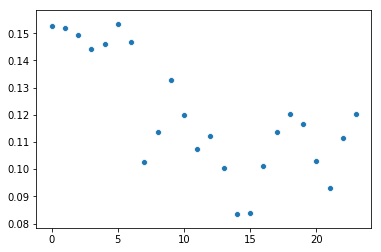

In [12]:
sns.scatterplot(y = data_x[255, :, 10, 14, 5], x = [x for x in range(24)])

In [13]:
min_all = []
max_all = []
for band in range(0, data_x.shape[-1]):

    mins, maxs = (np.min(data_x[:, :, :, :, band]), np.max(data_x[:, :, :, :, band]))
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (data_x[:, :, :, :, band] - midrange) / (rng / 2)
    data_x[:, :, :, :, band] = standardized
    
    min_all.append(mins)
    max_all.append(maxs)
    
print("The data has been scaled to [{}, {}]".format(np.min(data_x), np.max(data_x)))

The data has been scaled to [-1.0000001192092896, 1.0]


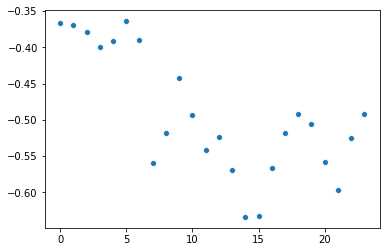

In [14]:
sns.scatterplot(y = data_x[255, :, 10, 14, 5], x = [x for x in range(24)])

# Split train, test

In [15]:
df = pd.read_csv("../data/subplot.csv")
df1 = pd.read_csv("../data/subplot2.csv")
df2 = pd.read_csv("../data/subplot3.csv")
df3 = pd.read_csv("../data/subplot4.csv")
df4 = pd.read_csv("../data/kenya-train.csv")

df = df.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df1 = df1.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df2 = df2.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df3 = df3.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
df4 = df4.drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)


lens = [len(x) for x in [df, df1, df2, df3, df4]]

df = pd.concat([df, df1, df2, df3, df4], ignore_index = True)
df = df.dropna(axis = 0)

existing = [int(x[:-4]) for x in os.listdir('../data/training-data-nov-22/') if ".DS" not in x]
N_SAMPLES = len(existing)
df = df[df['PLOT_ID'].isin(existing)]
N_SAMPLES = int(df.shape[0]/196)

plot_ids = sorted(df['PLOT_ID'].unique())
plot_ids2 = [val for x, val in enumerate(plot_ids) if x not in list(set([x for x in outliers]))]
N_SAMPLES = len(data_x)

# Positive (tree) and negative (background) pixel metrics

In [16]:
#! In development

positive_x = []
negative_x = []

#for sample in data_y:
#    for row in range(0,14):
#        for column in range(0,14):
#            if data_y[sample, row, column] == 1:

# Augment training data

Horizontal and vertical flips for 4x augmentation.

**To do**
*  Random guassian noise
*  Brightness, contrast
*  Region swaps (randomply position positive samples at different locations)

In [17]:
data_x_augmented = []
data_y_augmented = []
lengths_augmented = []

for i, val in enumerate([x for x in range(len(data_x))]):
    data_x_augmented.append(data_x[val])
    data_y_augmented.append(data_y[val])
    lengths_augmented.append(data_x[val].shape[0])
    
    x1 = np.flip(data_x[val], 1)
    y1 = np.flip(data_y[val], 0)
    lengths_augmented.append(x1.shape[0])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)
    
    x1 = np.flip(data_x[val], [2, 1])
    y1 = np.flip(data_y[val], [1, 0])
    lengths_augmented.append(x1.shape[0])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)
    
    x1 = np.flip(data_x[val], 2)
    y1 = np.flip(data_y[val], 1)
    lengths_augmented.append(x1.shape[0])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)

train_x = np.stack(data_x_augmented)
train_y = np.stack(data_y_augmented)
train_y = np.reshape(train_y, (train_y.shape[0], 14, 14, 1))
train_l = np.stack(lengths_augmented)
train_l = np.reshape(train_l, (train_y.shape[0], 1))

In [18]:
test_x = np.load("../data/processed/test_x_processed.npy")
test_y = np.load("../data/processed/test_y_processed.npy")
test_lengths = np.load("../data/processed/test_length_processed.npy")


below_1 = [i for i, val in enumerate(test_x) if np.min(val) < -1.05]
above_1 = [i for i, val in enumerate(test_x) if np.max(val) > 1.05]
min_vals = [np.min(val) for i, val in enumerate(test_x) if np.min(val) < -1.05]
max_vals = [np.max(val) for i, val in enumerate(test_x) if np.max(val) > 1.05]
outliers = below_1 + above_1
outliers = list(set(outliers))
print("The outliers are: {}, totalling {}".format(outliers, len(outliers)))
print("\n")
print(min_vals, max_vals)
test_x = test_x[[x for x in range(0, len(test_x)) if x not in outliers]]
test_y = test_y[[x for x in range(0, len(test_y)) if x not in outliers]]
test_lengths = test_lengths[[x for x in range(0, len(test_lengths)) if x not in outliers]]
print(np.min(test_x[19]))

for sample in tnrange(0, len(test_x)):
    filtered = median_filter(test_x[sample, 0, :, :, 10], size = 5)
    test_x[sample, :, :, :, 10] = np.stack([filtered] * 24)

#test_x = np.delete(test_x, 10, -1)
    
for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[:, :, :, :, band] = np.clip(test_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[:, :, :, :, band] - midrange) / (rng / 2)
    test_x[:, :, :, :, band] = standardized
    
print("The data has been scaled to [{}, {}]".format(np.min(test_x), np.max(test_x)))
print(test_x.shape)

The outliers are: [104, 108, 109, 120, 125], totalling 5


[-34.743225, -1.0604124, -1.3436636, -4.8844295] [1.2737346, 2.60685]
-1.0386096



The data has been scaled to [-1.0, 1.0]
(122, 24, 16, 16, 17)


In [19]:
print("Train and test characteristics:")
print("Train mean Y {}".format(np.mean([np.sum(x) for x in test_y])))
#print("Test mean Y {}".format(np.mean([np.sum(x) for x in data_y[test_ids]])))
#print("Train STD Y {}".format(np.std([np.sum(x) for x in data_y[train_ids]])))
print("Test STD Y {}".format(np.std([np.sum(x) for x in test_y])))
#print("Train number with zero trees {}".format(0.2*len([x for x in data_y[train_ids] if np.sum(x) == 0])))
#print("Test number with zero trees {}".format(0.8*len([x for x in data_y[test_ids] if np.sum(x) == 0])))
print("Train mean NDVI")
print("Test mean NDVI")
#print("There are {} train and {} test samples".format(len(train_ids), len(test_ids)))
#print("There is {} overlap between train and test".format(len([x for x in train_ids if x in test_ids])))

Train and test characteristics:
Train mean Y 35.78688524590164
Test STD Y 55.977341655556465
Train mean NDVI
Test mean NDVI


In [20]:
np.min(test_x[19, :, :, :])

-0.973816

# Loss definition

The current best loss is a combination of weighted binary cross entropy and per-image Lovasz-Softmax, with a loss schedule with the latter becoming more important each epoch

In [74]:
from keras.losses import binary_crossentropy
import math
from scipy.ndimage import distance_transform_edt as distance

def weighted_bce_loss(y_true, y_pred, weight, smooth = 0.025):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    y_true = K.clip(y_true, smooth, 1. - smooth)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )
    return tf.reduce_mean(loss)

def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res

def calc_dist_map_batch(y_true):
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)

def surface_loss(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)


def bce_lv(y_true, y_pred, alpha, smooth = 0.075, mask = None, ):
    bce = (0.99 - alpha) * weighted_bce_loss(y_true, y_pred, 1.5, smooth = smooth)
    #surf = surface_loss(y_true, y_pred)
    lv = (0.01 + alpha) * lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    #global_loss = (1 - alpha) * (bce + lv)
    #regional_loss = alpha * surf
    return bce+lv


def lovasz(y_true, y_pred):
    lv = lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    return lv

#! Move to a src.py
def calculate_metrics():
    best_f1 = 0
    best_thresh = 0
    p = 0
    r = 0
    error = 0
    ys = []
    vls = []
    t_alls = []
    test_ids = [x for x in range(len(test_x)) if x not in [11, 110, 3, 100, 47]]
    for test_sample in test_ids:
        y, vl = sess.run([fm, test_loss], feed_dict={inp: test_x[test_sample].reshape(1, 24, 16, 16, n_bands),
                                          length: test_lengths[test_sample].reshape(1, 1),
                                          is_training: False,
                                          labels: test_y[test_sample, :, :].reshape(1, 14, 14),
                                          })
        ys.append(y.reshape((14, 14)))
        vls.append(vl)
        t = test_y[test_sample].reshape((14, 14))
        t_alls.append(t)
    for thresh in range(8, 13):
        tps = []
        fps = []
        fns = []
        perc_error = []
        trues = []
        preds = []
        val_loss = []
        for sample in range(len(ys)):
            pred = np.copy(ys[sample])
            true = t_alls[sample]
            vl = vls[sample]
            pred[np.where(pred > thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            true_s = np.sum(true)
            pred_s = np.sum(pred)

            perc_error.append(abs(pred_s - true_s) / 196)
            tp, fp, fn = thirty_meter(true, pred)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            trues.append(true_s)
            preds.append(pred_s)
            val_loss.append(np.mean(vl))
        oa_error = abs(np.sum(preds) - np.sum(trues)) / np.sum(trues)
        precision = np.sum(tps) / (np.sum(tps) + np.sum(fps))
        recall = np.sum(tps) / (np.sum(tps) + np.sum(fns))
        f1 = 2*((precision* recall) / (precision + recall))
        if f1 > best_f1:
            best_f1 = f1
            p = precision
            r = recall
            error = oa_error
            best_thresh = thresh*0.05
    print("Val loss: {} Thresh: {} F1: {} Recall: {} Precision: {} Error: {}".format(np.around(np.mean(val_loss), 3), np.around(best_thresh, 2),
                                                                                     np.around(best_f1, 3), np.around(p, 3), np.around(r, 3), 
                                                                                     np.around(error, 3)))
    return best_f1

In [22]:
[np.percentile(np.sum(data_y, axis = (1, 2)), x) for x in range(0, 100, 10)]

[0.0, 0.0, 0.0, 0.0, 5.0, 12.0, 21.0, 32.0, 46.0, 82.10000000000014]

# Equibatch creation

In [23]:
train_ids = [x for x in range(0, len(train_y))]

def multiplot(matrices):
    '''Plot multiple heatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4)
    fig.set_size_inches(20, 4)
    for i, matrix in enumerate(matrices):
        sns.heatmap(data = matrix, ax = axs[i], vmin = 0, vmax = 0.9)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])
    plt.show()

def equibatch(train_ids, lovasz = False):
    first_len = 5
    second_len = 9
    third_len = 14
    np.random.shuffle(train_ids)
    ix = train_ids
    percs = [np.sum(x) for x in train_y[ix]]
    zero_ids = [x for x, z in zip(ix, percs) if z == 0]
    one_ids = [x for x, z in zip(ix, percs) if 0 < z <= first_len]
    two_ids = [x for x, z in zip(ix, percs) if first_len < z <= second_len]
    three_ids = [x for x, z in zip(ix, percs) if second_len < z <= third_len]
    four_ids = [x for x, z in zip(ix, percs) if third_len < z <= 19]
    five_ids = [x for x, z in zip(ix, percs) if 19 < z < 27]
    six_ids = [x for x, z in zip(ix, percs) if 27 < z <= 33]
    seven_ids = [x for x, z in zip(ix, percs) if 33 < z <= 41]
    eight_ids = [x for x, z in zip(ix, percs) if 41 < z <= 56]
    nine_ids =  [x for x, z in zip(ix, percs) if 56 < z <= 80]
    ten_ids =  [x for x, z in zip(ix, percs) if 80 < z <= 120]
    eleven_ids = [x for x, z in zip(ix, percs) if 120 < z]
    #ten_ids = [x for x, z in zip(ix, percs) if 125 < z]

    new_batches = []
    maxes = [len(zero_ids), len(one_ids), len(two_ids), len(three_ids), len(four_ids),
             len(five_ids), len(six_ids), len(seven_ids), len(eight_ids), len(nine_ids), len(ten_ids), len(eleven_ids)]#, len(ten_ids)]
    cur_ids = [0] * 12
    iter_len = len(train_ids)//(len(maxes)+3) if not lovasz else len(train_ids)//8
    for i in range(0, iter_len):
        for i, val in enumerate(cur_ids):
            if val > maxes[i] - 1:
                cur_ids[i] = 0
        if cur_ids[0] >= (maxes[0] - 2):
            cur_ids[0] = 0
        to_append = [zero_ids[cur_ids[0]], zero_ids[cur_ids[0] + 1], one_ids[cur_ids[1]], two_ids[cur_ids[2]],
                    three_ids[cur_ids[3]], four_ids[cur_ids[4]], five_ids[cur_ids[5]],
                    six_ids[cur_ids[6]], seven_ids[cur_ids[7]], eight_ids[cur_ids[8]],
                               nine_ids[cur_ids[9]], ten_ids[cur_ids[10]], eleven_ids[cur_ids[11]]]
        
        np.random.shuffle(to_append)
        new_batches.append(to_append)
        cur_ids = [x + 1 for x in cur_ids]
        cur_ids[0] += 1
        
    new_batches = [item for sublist in new_batches for item in sublist]
    #overlap = [x for x in new_batches if x in test_ids]
    #print("There is {} overlap. Error if > 0".format(len(overlap)))
    return new_batches

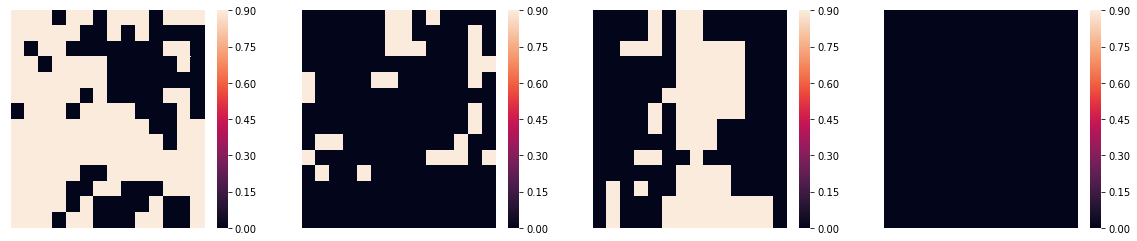

In [24]:
#! Todo: Move to one cell, rather than 3
batch = equibatch(train_ids, True)
multiplot([x.reshape((14, 14)) for x in train_y[batch[:4]]])

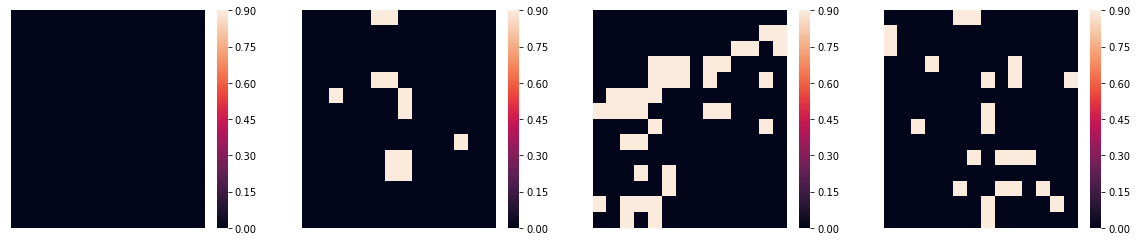

In [25]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[4:8]]])

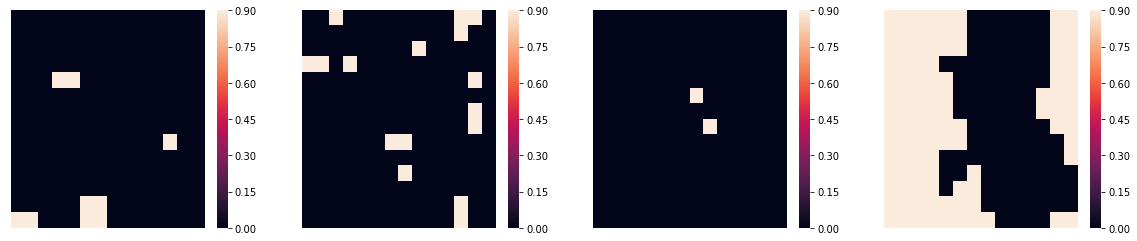

In [26]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[8:12]]])

In [27]:
# This cell should be run to do fine-tuning, if commented - train from scratch

#new_saver = tf.train.import_meta_graph('../models/new_model/model.meta')
#new_saver.restore(sess, tf.train.latest_checkpoint('../models/new_model/'))

# Graph set up

In [76]:
FRESH_START = True
best_val = 0.73

START_EPOCH = 1
END_EPOCH = 150
LEARNING_RATE = 1e-3
test_ids = [x for x in range(0, len(test_x))]


print("Starting model with: \n {} zone out \n {} l2 \n {} initial LR \n {} final LR \n {} parameters"
     .format(ZONE_OUT_PROB, L2_REG, INITIAL_LR, FINAL_LR, total_parameters))

if not FRESH_START:
    print("Resuming training with a best validation score of {}".format(best_val))
    
if FRESH_START:
    print("Restarting training from scratch on {} "
          "train and {} test samples, total {}".format(len(train_ids), len(test_ids), N_SAMPLES))

    optimizer = tf.train.AdamOptimizer(LEARNING_RATE, epsilon = 1e-8)
    train_loss = bce_lv(tf.reshape(labels, (-1, 14, 14, 1)), fm, alpha)
    l2_loss = tf.losses.get_regularization_loss()
    train_loss += l2_loss

    ft_optimizer = tf.train.GradientDescentOptimizer(0.01)
    ft_loss = bce_lv(tf.reshape(labels, (-1, 14, 14, 1)), fm, alpha)
    #wu_loss = weighted_bce_loss(tf.reshape(labels, (-1, 14, 14, 1)), fm, weight = 1.5)
    
    test_loss = weighted_bce_loss(tf.reshape(labels, (-1, 14, 14, 1)), fm, weight = 1.)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(train_loss)   
        ft_op = ft_optimizer.minimize(ft_loss)
        
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 2)
    
print("The graph has been finalized")

Starting model with: 
 0.35 zone out 
 0.0 l2 
 0.0002 initial LR 
 0.001 final LR 
 95927 parameters
Restarting training from scratch on 2856 train and 122 test samples, total 714
()
()
The graph has been finalized


# Model training

In [119]:
best_val = 0.748

train_ids = [x for x in range(len(train_y))]

for i in range(4, 200):
    al = np.min([i*0.002, 0.04])
    #randomize = train_ids
    #np.random.shuffle(randomize)
    randomize = equibatch(train_ids, lovasz = False)
    if i > 125:
        print("Switching to SGD")
        op = ft_op
        loss = ft_loss
    else:
        print("Loss: {} 1.5 weighted BCE + {} Image Lovasz".format( (0.99-al), (0.01 + al)))
        op = train_op
        loss = train_loss
        #op = ft_op
        #loss = ft_loss
    BATCH_SIZE = 32
    test_ids = [x for x in range(0, len(test_x))]
    losses = []
    
    for k in tnrange(int(len(randomize) // BATCH_SIZE)):
        batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
        batch_y = train_y[batch_ids, :, :].reshape(len(batch_ids), 14, 14)
        opt, tr = sess.run([op, loss],
                              feed_dict={inp: train_x[batch_ids, :, :, :],
                                         length: train_l[batch_ids].reshape((-1, 1)),
                                         labels: batch_y,
                                         is_training: True,
                                         keep_rate: np.max((1 - (i*0.005), 0.90)),
                                         alpha: al
                                         })
        losses.append(tr)
    
    print("Epoch {}: Loss {}".format(i, np.around(np.mean(losses[:-1]), 3)))
    f1 = calculate_metrics()
    if f1 > best_val:
        best_val = f1
        print("Saving model with {}".format(f1))
        save_path = saver.save(sess, "../models/nov-24-fpa/model")

Loss: 0.982 1.5 weighted BCE + 0.018000000000000002 Image Lovasz


Epoch 4: Loss 0.5199999809265137
Val loss: 0.3630000054836273 Thresh: 0.6 F1: 0.721 Recall: 0.708 Precision: 0.734 Error: 0.037
Loss: 0.98 1.5 weighted BCE + 0.02 Image Lovasz


Epoch 5: Loss 0.5199999809265137
Val loss: 0.3569999933242798 Thresh: 0.6 F1: 0.727 Recall: 0.72 Precision: 0.734 Error: 0.02
Loss: 0.978 1.5 weighted BCE + 0.022 Image Lovasz


Epoch 6: Loss 0.5180000066757202
Val loss: 0.3580000102519989 Thresh: 0.6 F1: 0.717 Recall: 0.71 Precision: 0.724 Error: 0.02
Loss: 0.976 1.5 weighted BCE + 0.024 Image Lovasz


Epoch 7: Loss 0.5180000066757202
Val loss: 0.3490000069141388 Thresh: 0.6 F1: 0.725 Recall: 0.73 Precision: 0.72 Error: 0.014
Loss: 0.974 1.5 weighted BCE + 0.026000000000000002 Image Lovasz


Epoch 8: Loss 0.515999972820282
Val loss: 0.34700000286102295 Thresh: 0.6 F1: 0.726 Recall: 0.735 Precision: 0.718 Error: 0.022
Loss: 0.972 1.5 weighted BCE + 0.028000000000000004 Image Lovasz


Epoch 9: Loss 0.515999972820282
Val loss: 0.34700000286102295 Thresh: 0.6 F1: 0.726 Recall: 0.725 Precision: 0.727 Error: 0.002
Loss: 0.97 1.5 weighted BCE + 0.03 Image Lovasz


Epoch 10: Loss 0.5170000195503235
Val loss: 0.3529999852180481 Thresh: 0.6 F1: 0.725 Recall: 0.717 Precision: 0.733 Error: 0.023
Loss: 0.968 1.5 weighted BCE + 0.032 Image Lovasz


Epoch 11: Loss 0.5170000195503235
Val loss: 0.3540000021457672 Thresh: 0.6 F1: 0.723 Recall: 0.72 Precision: 0.726 Error: 0.008
Loss: 0.966 1.5 weighted BCE + 0.034 Image Lovasz


Epoch 12: Loss 0.515999972820282
Val loss: 0.3449999988079071 Thresh: 0.6 F1: 0.732 Recall: 0.74 Precision: 0.724 Error: 0.021
Loss: 0.964 1.5 weighted BCE + 0.036000000000000004 Image Lovasz


Epoch 13: Loss 0.515999972820282
Val loss: 0.35199999809265137 Thresh: 0.55 F1: 0.725 Recall: 0.701 Precision: 0.75 Error: 0.07
Loss: 0.962 1.5 weighted BCE + 0.038 Image Lovasz


Epoch 14: Loss 0.5149999856948853
Val loss: 0.34700000286102295 Thresh: 0.55 F1: 0.731 Recall: 0.71 Precision: 0.754 Error: 0.062
Loss: 0.96 1.5 weighted BCE + 0.04 Image Lovasz


Epoch 15: Loss 0.515999972820282
Val loss: 0.33799999952316284 Thresh: 0.6 F1: 0.731 Recall: 0.743 Precision: 0.72 Error: 0.031
Loss: 0.958 1.5 weighted BCE + 0.042 Image Lovasz


Epoch 16: Loss 0.515999972820282
Val loss: 0.34200000762939453 Thresh: 0.55 F1: 0.731 Recall: 0.713 Precision: 0.75 Error: 0.053
Loss: 0.956 1.5 weighted BCE + 0.044000000000000004 Image Lovasz


KeyboardInterrupt: 

In [543]:
# potential problem test IDS: 135505813, 135505835, 
save_path = saver.save(sess, "../models/nov-21/model")


In [120]:
calculate_metrics()

Val loss: 0.3449999988079071 Thresh: 0.55 F1: 0.734 Recall: 0.703 Precision: 0.768 Error: 0.092


0.734240687679083

# Model validation and sanity checks





In [121]:
start = 0
test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    '''Plot multiple heatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(20, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show()
start = 47

0.38524590163934425
47
48
49
50
51
52
53
54


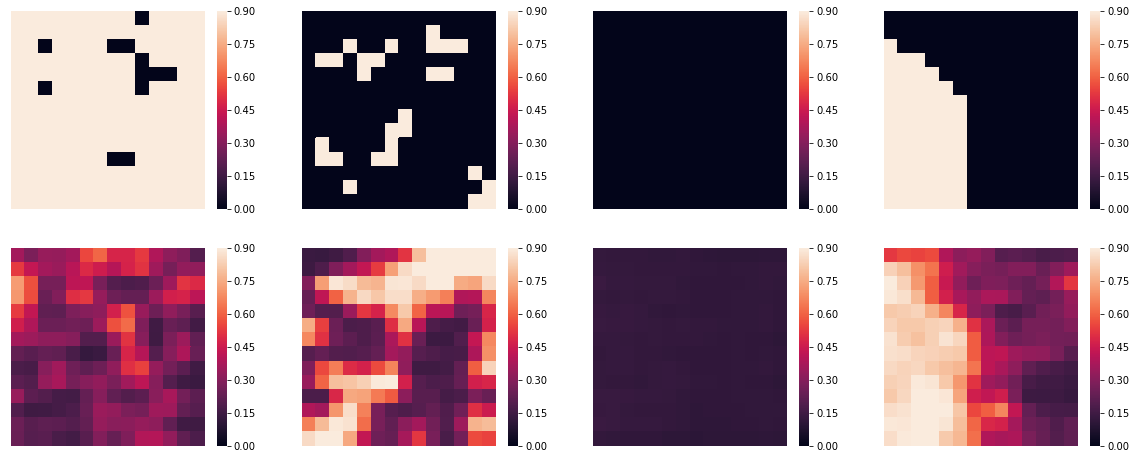

In [122]:
test_losses = []
print(start/len(test_ids))
test_ids = sorted(test_ids)
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
#matrix_ids = random.sample(test_ids, 4)z

preds = []
trues = []
for i in matrix_ids:
    idx = i
    print(i)
    y = sess.run([fm], feed_dict={inp: test_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: test_lengths[idx].reshape(1, 1),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    preds.append(y)
    true = test_y[idx].reshape(14, 14)
    trues.append(true)
    
""
to_plot = trues[0:4] + preds[0:4]# + trues[5:] + preds[5:]
multiplot(to_plot, nrows = 2, ncols = 4)
#plot_ids[/ordering[976]//4] 
start = start + 4 # 50, 87, 107 is a concern

1714
1453
1954
657


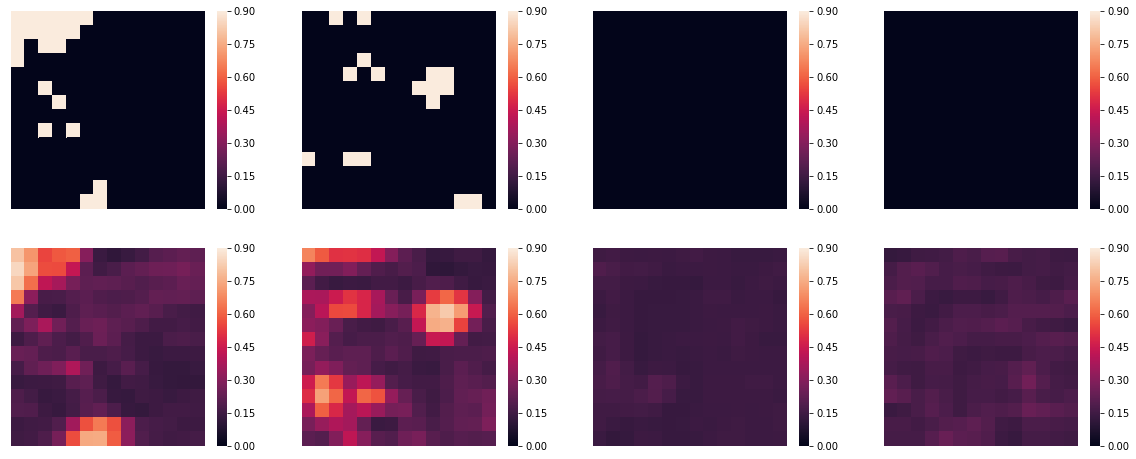

In [47]:
test_losses = []
test_ids = sorted(test_ids)
matrix_ids = random.sample(train_ids, 4)
#matrix_ids = [len(train_x)-28]

preds = []
trues = []
for i in matrix_ids:
    idx = i
    print(i)
    y = sess.run([fm], feed_dict={inp: train_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: train_l[idx].reshape(1, 1),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    preds.append(y)
    true = train_y[idx].reshape(14, 14)
    trues.append(true)
    

to_plot = trues[0:4] + preds[0:4]# + trues[5:] + preds[5:]
multiplot(to_plot, nrows = 2, ncols = 4)

In [511]:
plot_ids2 = [val for x, val in enumerate(plot_ids) if x not in list(set([x // 4 for x in outliers]))]
#plot_ids2[ordering[460]//4] 

In [153]:
calculate_metrics()

Val loss: 0.32100000977516174 Thresh: 0.4 F1: 0.697 Recall: 0.699 Precision: 0.695 Error: 0.005


0.6968058968058969

## TODO @jombrandt top 10 worst training, test samples by IOU 

These should be written to a tmp/ .txt file and indexed by validate-data.ipynb to ensure that original classifications were correct, and to identify regions that need more training data.